In [1]:
import matplotlib
import matplotlib.pyplot as plt

import os
import random
import skimage
from skimage import io
import imageio
import glob
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage

import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder

%matplotlib inline

In [2]:
def load_image_into_numpy_array(path):
    img = io.imread(path)
    (width, height) = img.shape
    if img.ndim !=3:
        img = skimage.color.gray2rgb(img)
    img_arr = np.array(img).reshape((width, height, 3)).astype(np.uint8)
    return img_arr



In [3]:
pipeline_config = "./model.config"
model_dir = '/data/embryo/mask_rcnn/data/model-4-008/'
configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
detection_model  = model_builder.build(model_config=model_config, is_training=False)




In [4]:
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join('/data/embryo/mask_rcnn/data/model-4-008/ckpt-636'))

In [5]:
def get_model_detection_function(model):
  """Get a tf.function for detection."""

  @tf.function
  def detect_fn(image):
    """Detect objects in image."""

    image, shapes = model.preprocess(image)
    prediction_dict = model.predict(image, shapes)
    detections = model.postprocess(prediction_dict, shapes)

    return detections, prediction_dict, tf.reshape(shapes, [-1])

  return detect_fn

detect_fn = get_model_detection_function(detection_model)

In [6]:
label_map_path = configs['eval_input_config'].label_map_path
label_map = label_map_util.load_labelmap(label_map_path)
categories = label_map_util.convert_label_map_to_categories(
    label_map,
    max_num_classes=label_map_util.get_max_label_map_index(label_map),
    use_display_name=True)
category_index = label_map_util.create_category_index(categories)
label_map_dict = label_map_util.get_label_map_dict(label_map, use_display_name=True)

INFO:tensorflow:depth of additional conv before box predictor: 0
Instructions for updating:
box_ind is deprecated, use box_indices instead
Instructions for updating:
Use ref() instead.
Instructions for updating:
`tf.batch_gather` is deprecated, please use `tf.gather` with `batch_dims=-1` instead.


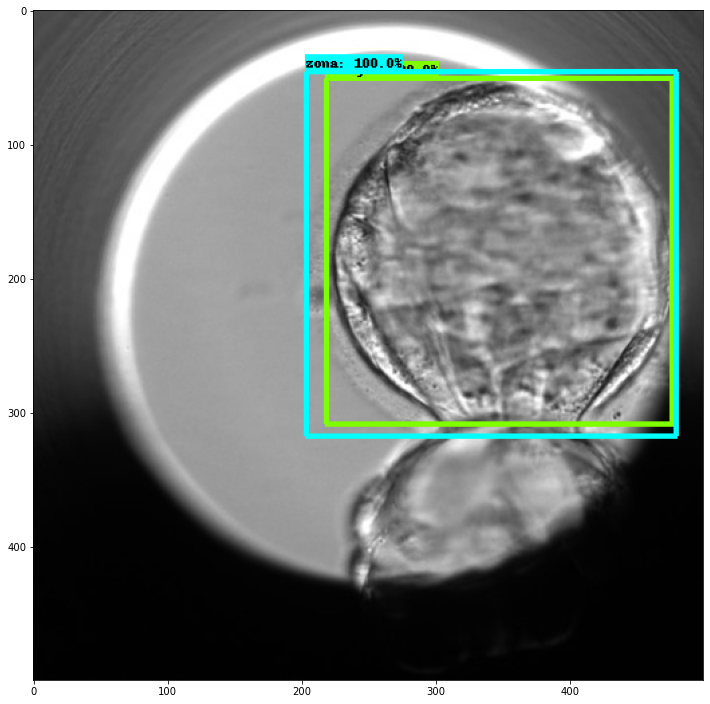

In [7]:
image_path = "/data/embryo/img/D2016_05_31_S0031_I776_E8/D2016_05_31_S0031_I776_E8_8093.jpg"
image_np = load_image_into_numpy_array(image_path)
input_tensor = tf.convert_to_tensor(
    np.expand_dims(image_np, 0), dtype=tf.float32)
detections, predictions_dict, shapes = detect_fn(input_tensor)

label_id_offset = 1
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_detections,
      detections['detection_boxes'][0].numpy(),
      (detections['detection_classes'][0].numpy() + label_id_offset).astype(int),
      detections['detection_scores'][0].numpy(),
      category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=2,
      min_score_thresh=0.5,
      agnostic_mode=False,
)

plt.figure(figsize=(12,16))
plt.imshow(image_np_with_detections)
plt.show()

In [14]:
def bbsize(list):
    y_min = list[0]
    x_min = list[1]
    y_max = list[2]
    x_max = list[3]

    width = x_max - x_min
    height = y_max - y_min

    size = width * height
    return size


In [12]:
float(detections['detection_scores'][0].numpy().tolist()[0])

1.0

In [23]:
category_index

{1: {'id': 1, 'name': 'embryo'}, 2: {'id': 2, 'name': 'zona'}}

In [24]:
for i in range(2):
    list = detections['detection_boxes'][0].numpy()[i].tolist()
    size = bbsize(list)
    class_int = (detections['detection_classes'][0].numpy() + label_id_offset).astype(int)[i]
    class_name = category_index[class_int]['name']
    print("Class name: {}, Size: {}".format(class_name, size))


Class name: embryo, Size: 0.26575419948922674
Class name: zona, Size: 0.30135147550878627
